# <br> Autoencoder-based anomaly detection

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### <br> Load data (realized transitions)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv('transitions.csv', header=None)
X_train, X_test = train_test_split(data.values, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape, X_test.shape)
n_inputs, n_outputs, n_hidden = (X_train.shape[1] for i in range(3))

(2093, 55) (524, 55)


In [4]:
import tensorflow as tf
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)

#### <br> Building dataflow graph

In [7]:
learning_rate=0.01
reset_graph()
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.sigmoid)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.sigmoid)
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
errors = tf.reduce_mean(tf.square(outputs - X), axis=1)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()

#### <br> Training the model

In [8]:
from tqdm import trange
plot_x, plot_y, plot_y2 = ([] for i in range(3))
n_iterations = 10000
with tf.Session() as sess:
    init.run()
    for iteration in trange(n_iterations):
        _,c = sess.run([training_op,reconstruction_loss], feed_dict={X: X_train})
        c2 = sess.run([reconstruction_loss], feed_dict={X: X_test})
        plot_x.append(iteration)
        plot_y.append(c)
        plot_y2.append(c2)
            
    saver.save(sess, "anomaly_model.ckpt")

100%|██████████| 10000/10000 [00:49<00:00, 201.01it/s]


#### <br> Plot training and test loss

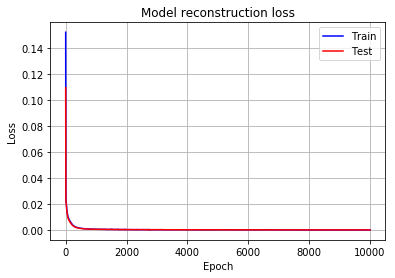

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(plot_x, plot_y, 'b', plot_x, plot_y2, 'r')
plt.title('Model reconstruction loss')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
#plt.style.use(['dark_background'])
plt.show()

In [10]:
import numpy as np
with tf.Session() as sess:
    saver.restore(sess, 'anomaly_model.ckpt')
    _, train_errors = sess.run([reconstruction_loss, errors], feed_dict={X: X_train})
    print("Train errors: ", np.min(train_errors), np.max(train_errors), np.mean(train_errors), np.std(train_errors))
    _, test_errors = sess.run([reconstruction_loss, errors], feed_dict={X: X_test})
    print("Test errors: ", np.min(test_errors), np.max(test_errors), np.mean(test_errors), np.std(test_errors))
    above_test_errors = test_errors[test_errors < np.max(train_errors)]
    print("% of test errors below train max: ", 100 * len(above_test_errors)/len(test_errors))

INFO:tensorflow:Restoring parameters from anomaly_model.ckpt
Train errors:  7.21495e-06 0.000921529 7.22132e-05 8.88566e-05
Test errors:  7.17074e-06 0.00124758 8.82292e-05 0.000127633
% of test errors below train max:  99.23664122137404
